# Web scraping and analysis

---

## Scraping data from Skytrax

We are only interested in reviews related to British Airways and the Airline itself.

We can find all useful data here : [https://www.airlinequality.com/airline-reviews/british-airways], and we'll use `BeautifulSoup` to collect the links to the reviews and then to collect the text data on each of the individual review links.

---

### Importing libraries

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
#nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import spacy
from gensim import corpora
from gensim.models import LdaModel
from collections import Counter

2023-11-12 15:27:59.249373: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Scraping

In [2]:
# We scrap the first 10 pages
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


**=> We collected 1000 reviews**

### Loading the scraped data into a DataFrame

In [3]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,✅ Trip Verified | Booked a flight from Buchar...
1,✅ Trip Verified | Booked online months ago an...
2,✅ Trip Verified | The flight was on time. The...
3,"Not Verified | Angry, disappointed, and unsat..."
4,"✅ Trip Verified | As an infrequent flyer, Bri..."


In [4]:
# Record the data into a CSV file
df.to_csv("BA_reviews.csv")

### Data cleaning

We'll remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [5]:
ba_data = pd.read_csv('BA_reviews.csv')

In [6]:
# Define a function to clean each review
def clean_review(review):
    # Remove "✅ Trip Verified" if it exists
    review = review.replace("✅ Trip Verified |", "")
    # Remove "Not Verified" if it exists
    review = review.replace("Not Verified |", "")
    # Strip leading and trailing whitespaces
    review = review.strip()
    return review

# Apply the clean_review function to the 'reviews' column
ba_data['cleaned_reviews'] = ba_data['reviews'].apply(clean_review)

# Display the cleaned data
print(ba_data[['reviews', 'cleaned_reviews']])

                                               reviews  \
0    ✅ Trip Verified |  Booked a flight from Buchar...   
1    ✅ Trip Verified |  Booked online months ago an...   
2    ✅ Trip Verified |  The flight was on time. The...   
3    Not Verified |  Angry, disappointed, and unsat...   
4    ✅ Trip Verified |  As an infrequent flyer, Bri...   
..                                                 ...   
995  ✅ Trip Verified |  \r\nVenice to London City. ...   
996  ✅ Trip Verified |  San Francisco to London. Te...   
997  ✅ Trip Verified |  Heathrow to Vancouver. The ...   
998  ✅ Trip Verified |  London to Bucharest. First ...   
999  ✅ Trip Verified |  I forgot I had purchased a ...   

                                       cleaned_reviews  
0    Booked a flight from Bucharest to Manchester w...  
1    Booked online months ago and the only hitch wa...  
2    The flight was on time. The crew were polite. ...  
3    Angry, disappointed, and unsatisfied. My route...  
4    As an infrequ

In [7]:
# Function to clean the text
def clean_text(text):
    # Remove special characters, numbers, and unnecessary whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    return text

In [8]:
# Apply text cleaning to the 'reviews' column
ba_data['cleaned_reviews'] = ba_data['cleaned_reviews'].apply(clean_text)
ba_data.head()

,Unnamed: 0,reviews,cleaned_reviews
0,0,✅ Trip Verified | Booked a flight from Buchar...,booked flight bucharest manchester h layover h...
1,1,✅ Trip Verified | Booked online months ago an...,booked online months ago hitch replacement air...
2,2,✅ Trip Verified | The flight was on time. The...,flight time crew polite story outward flight f...
3,3,"Not Verified | Angry, disappointed, and unsat...",angry disappointed unsatisfied route london at...
4,4,"✅ Trip Verified | As an infrequent flyer, Bri...",infrequent flyer british airways always first ...


### Sentiment analysis

In [9]:
# Perform sentiment analysis
sia = SentimentIntensityAnalyzer()
ba_data['sentiment_score'] = ba_data['cleaned_reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])
ba_data.head()

,Unnamed: 0,reviews,cleaned_reviews,sentiment_score
0,0,✅ Trip Verified | Booked a flight from Buchar...,booked flight bucharest manchester h layover h...,-0.8227
1,1,✅ Trip Verified | Booked online months ago an...,booked online months ago hitch replacement air...,0.2235
2,2,✅ Trip Verified | The flight was on time. The...,flight time crew polite story outward flight f...,0.1280
3,3,"Not Verified | Angry, disappointed, and unsat...",angry disappointed unsatisfied route london at...,-0.6705
4,4,"✅ Trip Verified | As an infrequent flyer, Bri...",infrequent flyer british airways always first ...,-0.1027


In [10]:
# Perform sentiment analysis on each review
sentiments = [sia.polarity_scores(review)['compound'] for review in reviews]

# Classify sentiments into Positive, Neutral, and Negative
positive_count = sum(sentiment > 0 for sentiment in sentiments)
neutral_count = sum(sentiment == 0 for sentiment in sentiments)
negative_count = sum(sentiment < 0 for sentiment in sentiments)

# Calculate percentages
total_reviews = len(reviews)
positive_percentage = (positive_count / total_reviews) * 100
neutral_percentage = (neutral_count / total_reviews) * 100
negative_percentage = (negative_count / total_reviews) * 100

# Print the results
print(f"Positive: {positive_percentage}%")
print(f"Neutral: {neutral_percentage}%")
print(f"Negative: {negative_percentage}%")

Positive: 49.4%
Neutral: 0.5%
Negative: 50.1%


### Tokenization and Lemmatization

Tokenization and lemmatization aim to process text data for analysis. Tokenization involves breaking text into individual words or tokens, facilitating further analysis. Lemmatization refines this by reducing words to their base or root form, improving consistency in word representation for more meaningful insights.

In [11]:
# Load spaCy model for English
nlp = spacy.load('en_core_web_sm')

# Apply tokenization and lemmatization to the 'cleaned_reviews' column
ba_data['tokenized_reviews'] = ba_data['cleaned_reviews'].apply(
    lambda x: [token.lemma_ for token in nlp(x) if not token.is_stop])
ba_data.head()

,Unnamed: 0,reviews,cleaned_reviews,sentiment_score,tokenized_reviews
0,0,✅ Trip Verified | Booked a flight from Buchar...,booked flight bucharest manchester h layover h...,-0.8227,"[book, flight, bucharest, manchester, h, layov..."
1,1,✅ Trip Verified | Booked online months ago an...,booked online months ago hitch replacement air...,0.2235,"[book, online, month, ago, hitch, replacement,..."
2,2,✅ Trip Verified | The flight was on time. The...,flight time crew polite story outward flight f...,0.1280,"[flight, time, crew, polite, story, outward, f..."
3,3,"Not Verified | Angry, disappointed, and unsat...",angry disappointed unsatisfied route london at...,-0.6705,"[angry, disappointed, unsatisfie, route, londo..."
4,4,"✅ Trip Verified | As an infrequent flyer, Bri...",infrequent flyer british airways always first ...,-0.1027,"[infrequent, flyer, british, airways, choice, ..."


In [12]:
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(ba_data['tokenized_reviews'])

# Convert to bag-of-words corpus
corpus = [dictionary.doc2bow(text) for text in ba_data['tokenized_reviews']]

# Create a list of word-frequency pairs from the second document in the corpus
words = [(dictionary[idx], count) for idx, count in corpus[1]]
print(words)

[('arrive', 1), ('book', 1), ('delay', 1), ('flight', 1), ('fly', 1), ('food', 1), ('later', 1), ('lhr', 1), ('not', 2), ('staff', 1), ('time', 2), ('actually', 1), ('ago', 1), ('aircraft', 1), ('amend', 1), ('arm', 1), ('bag', 1), ('boarding', 1), ('break', 1), ('breakfast', 1), ('cabin', 1), ('carousel', 1), ('case', 1), ('choose', 1), ('clean', 1), ('complaint', 1), ('cpt', 2), ('departure', 1), ('different', 1), ('drink', 1), ('drop', 1), ('especially', 1), ('expect', 1), ('far', 1), ('fault', 1), ('george', 1), ('good', 1), ('hitch', 1), ('hour', 1), ('inform', 1), ('land', 1), ('late', 1), ('leave', 1), ('leg', 1), ('likely', 1), ('little', 1), ('load', 1), ('man', 2), ('mean', 2), ('month', 1), ('notice', 1), ('ointment', 1), ('online', 1), ('option', 1), ('pe', 1), ('perk', 1), ('pleasant', 1), ('plus', 1), ('prior', 1), ('recline', 1), ('replacement', 1), ('room', 1), ('rush', 1), ('seat', 2), ('service', 1), ('shuttle', 1), ('slow', 1), ('smooth', 1), ('sufficient', 1), ('sur

### Topic modeling using LDA

The aim of the topic modeling using Latent Dirichlet Allocation (LDA) is to uncover latent topics within a collection of text documents. LDA identifies patterns of word co-occurrence to assign documents to topics, allowing for the extraction of meaningful themes present in the textual data. This facilitates a structured understanding of the underlying topics and aids in content summarization or categorization.

In [13]:
# Train the LDA model
lda_model = LdaModel(corpus, num_topics=2, id2word=dictionary, passes=10)

# Display the topics
print("LDA Topics:")
for topic_num, words in lda_model.print_topics():
    print(f"Topic #{topic_num + 1}: {words}\n")

LDA Topics:
Topic #1: 0.032*"flight" + 0.017*"ba" + 0.014*"not" + 0.010*"hour" + 0.009*"london" + 0.008*"book" + 0.008*"customer" + 0.008*"time" + 0.008*"tell" + 0.008*"cancel"

Topic #2: 0.029*"flight" + 0.017*"seat" + 0.016*"ba" + 0.013*"service" + 0.010*"good" + 0.009*"crew" + 0.009*"food" + 0.009*"time" + 0.008*"staff" + 0.008*"cabin"



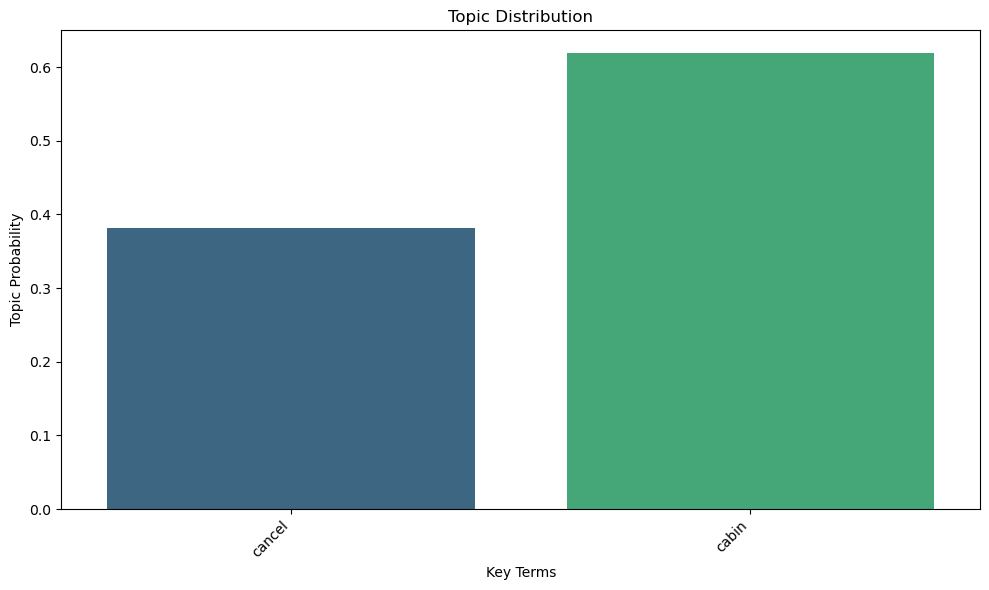

In [14]:
# Display the topics
topics = [words for topic_num, words in lda_model.print_topics()]

# Extract key terms for each topic
key_terms = [term.split('*')[-1].strip().strip('"') for term in topics]

# We want to visualize the topic distribution for the third document
doc_topic_distribution = lda_model[corpus][2]

# Extracting topic probabilities
probabilities = [prob for topic, prob in doc_topic_distribution]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=key_terms, y=probabilities, palette="viridis")
plt.title('Topic Distribution')
plt.xlabel('Key Terms')
plt.ylabel('Topic Probability')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Wordcloud

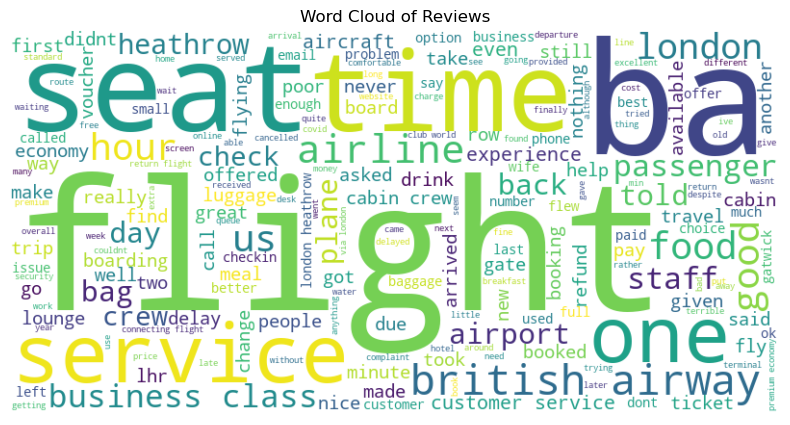

In [15]:
# Generate the Wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(ba_data['cleaned_reviews']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Reviews')
plt.show()

### Distribution of words

Top Word Frequencies:
flight: 1871
ba: 1145
service: 711
london: 553
time: 493
seat: 450
food: 444
crew: 436
british: 415
good: 412
airways: 412
class: 412
one: 411
seats: 409
staff: 403
us: 397
business: 376
cabin: 367
would: 365
get: 362


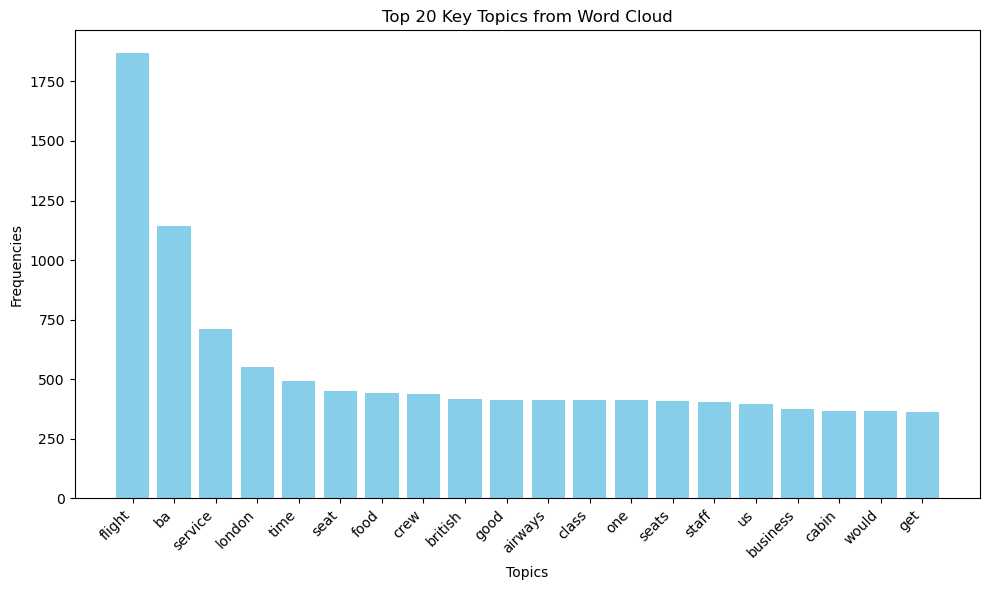

In [16]:
# Combine cleaned reviews into a single string
text_data = ' '.join(ba_data['cleaned_reviews'])

# Tokenize the text (split it into words)
#words = text_data.lower().split()
words = text_data.split()

# Count word frequencies
word_frequencies = Counter(words)

# Sort word frequencies in descending order
sorted_word_frequencies = dict(sorted(word_frequencies.items(), key=lambda item: item[1], reverse=True))

# Take only the top 20 word frequencies
top_word_frequencies = dict(list(sorted_word_frequencies.items())[:20])

# Print top word frequencies (optional)
print("Top Word Frequencies:")
for word, frequency in top_word_frequencies.items():
    print(f"{word}: {frequency}")

# Generate word cloud
#wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_frequencies)

# Extract key topics and their frequencies for the bar chart
key_topics = list(top_word_frequencies.keys())
frequencies = list(top_word_frequencies.values())

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(key_topics, frequencies, color='skyblue')
plt.xlabel('Topics')
plt.ylabel('Frequencies')
plt.title('Top 20 Key Topics from Word Cloud')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()